# WeMoms Homework

### Imports

In [43]:
import pandas as pd
from datetime import date

### Load the raw data

In [3]:
DATA_PATH = "../data/raw/WeMoms_MLE_hiring_test_2023.json.gzip"
df = pd.read_json(
    path_or_buf=DATA_PATH,
    lines=True,
    compression="gzip"
).drop_duplicates(subset=[
    "trackable_id",
    "user_id",
    "tracker_created_at"
])

## Exploration

In [4]:
df.head()

,trackable_id,user_id,tracker_created_at,user_is_mom,user_is_pregnant,user_is_trying,user_country_code,post_age_in_minutes,author_children_count,author_maternity_stage,...,user_followings_count,user_posts_count,user_received_comments_count,user_pictures_count,user_likes_count,user_children_count,user_children_age_month,author_amenorrhea_week,user_department,first_comment_at
0,1931624c-a21b-11ed-b184-5e66837db5da,215b3aec-6dc3-11ed-a80a-8a8030e96d2b,2023-02-01 11:44:12.326601+00:00,False,True,False,FR,75,1,mom,...,16,49,135,22,406,0,[],NaN,NaN,NaT
1,9c80a07e-a219-11ed-be3a-4600178b2407,087ab5c6-2c8b-11ed-b750-f67139482fad,2023-02-01 10:21:21.408694+00:00,False,True,False,FR,3,3,pregnant,...,10,40,101,20,526,0,[],20.0,NaN,NaT
2,5790182e-a231-11ed-b7c5-7a9191da5dac,27d08520-06cc-11ed-8718-2aee9156f1f7,2023-02-01 14:07:20.156591+00:00,False,True,False,FR,60,0,pregnant,...,0,74,469,22,779,0,[],26.0,NaN,NaT
3,9962a4e6-a1b5-11ed-8856-52aeb15ae5c4,1dd94cd2-60d1-11ed-8971-260a25888951,2023-02-01 00:46:49.527356+00:00,False,True,False,FR,141,0,pregnant,...,0,3,64,0,50,0,[],28.0,NaN,NaT
4,ebcb05cc-a1ef-11ed-812d-3e85771f591b,8d853776-4f92-11ed-98bb-de9f120fe24b,2023-02-01 05:57:05.024779+00:00,False,True,False,FR,37,0,pregnant,...,0,0,0,0,0,0,[],22.0,NaN,NaT


In [5]:
df.loc[0]

trackable_id                        1931624c-a21b-11ed-b184-5e66837db5da
user_id                             215b3aec-6dc3-11ed-a80a-8a8030e96d2b
tracker_created_at                      2023-02-01 11:44:12.326601+00:00
user_is_mom                                                        False
user_is_pregnant                                                    True
user_is_trying                                                     False
user_country_code                                                     FR
post_age_in_minutes                                                   75
author_children_count                                                  1
author_maternity_stage                                               mom
post_comments_count                                                   15
post_likes_count                                                       0
survey_answers_count                                                   0
has_picture                                        

Add a column which specify if the post is from yesterday

In [6]:
post_age = (df.tracker_created_at - df.post_age_in_minutes.apply(lambda x: pd.Timedelta(minutes=x))).dt.date
post_age_plus_one = post_age.apply(lambda x: x + pd.Timedelta(days=1))
df["post_from_yesterday"] = df.tracker_created_at.dt.date == post_age_plus_one

Visual check

In [7]:
df[["tracker_created_at", "post_age_in_minutes", "post_from_yesterday"]].sort_values("post_from_yesterday")

,tracker_created_at,post_age_in_minutes,post_from_yesterday
0,2023-02-01 11:44:12.326601+00:00,75,False
64523,2023-01-22 22:51:10.772754+00:00,395,False
64522,2023-01-22 11:53:43.937820+00:00,223,False
64520,2023-01-22 09:24:09.217764+00:00,106,False
64519,2023-01-22 06:59:46.339396+00:00,314,False
...,...,...,...
18149,2023-01-11 14:14:11.249078+00:00,1460,True
91231,2023-01-04 21:49:02.183295+00:00,1478,True
79381,2023-01-22 04:38:21.637033+00:00,546,True
36185,2023-01-30 07:11:04.437637+00:00,480,True


In [8]:
df.trackable_id.value_counts().to_frame().groupby("trackable_id").size()

trackable_id
1     68025
2     11822
3      2023
4       361
5        69
6        15
7         2
8         2
11        1
15        2
18        1
20        4
22        1
23        1
26        1
29        1
dtype: int64

### Compute new features

In [9]:
df["user_children_age_year"] = df.user_children_age_month.apply(lambda x: [i//12 for i in x])

In [10]:
# Author children count
df['author_children_count'] = df['author_children_age_month'].transform(len)

# user_children_age_year
df["user_children_age_year"] = df.user_children_age_month.apply(lambda x: [i//12 for i in x])

# Author has same age children
df["author_has_same_age_children"] = df.apply(
    lambda x: len(set(x.author_children_age_year).intersection(set(x.user_children_age_year))) > 0,
    axis=1
)

# Author has same age children
df["author_has_same_age_month_children"] = df.apply(
    lambda x: len(set(x.author_children_age_month).intersection(set(x.user_children_age_month))) > 0,
    axis=1
)

# Author has older children than user
df["author_has_older_children"] = df.apply(
    lambda x: max(x.author_children_age_year, default=-1) > max(x.user_children_age_year, default=-1),
    axis=1
)

In [11]:
def add_post_past_popularity(df, window):
    print(f"Doing {window}")
    return (df
     .merge(df[["tracker_created_at", "trackable_id", "has_been_opened"]]
              .set_index('tracker_created_at')
              .sort_index()
              .groupby('trackable_id', sort=False)
              .has_been_opened
              .rolling(window, closed='left')
              .agg({
                  f"post_last_{window}_views_count": len,
                  f"post_last_{window}_clicks_count": sum,
                  f"post_last_{window}_ratio": lambda x: sum(x)/len(x)
              })
              .fillna(0),
        left_on=['trackable_id', 'tracker_created_at'],
        right_index=True
        )
    )

In [12]:
# How many time the post was viewed/clicked before
df = add_post_past_popularity(df, "28d")
df = add_post_past_popularity(df, "7d")
df = add_post_past_popularity(df, "1d")

Doing 28d
Doing 7d
Doing 1d


In [13]:
# Action of the user with the same post in the past

In [14]:
def add_user_post_past_popularity(df, window):
    print(f"Doing {window}")
    return (df[["tracker_created_at", "trackable_id", "user_id", "has_been_opened"]]
              .set_index('tracker_created_at')
              .sort_index()
              .groupby(['trackable_id', "user_id"], sort=False)
              .has_been_opened
              .rolling(window, closed='left')
              .agg({
                  f"user_post_last_{window}_views_count": len,
                  f"user_post_last_{window}_clicks_count": sum,
                  f"user_post_last_{window}_ratio": lambda x: sum(x)/len(x)
              })
              .fillna(0).reset_index())


In [15]:
user_post_past_popularity = add_user_post_past_popularity(df, "28d")

Doing 28d


In [16]:
df = pd.merge(df, user_post_past_popularity, on=["trackable_id", "user_id", "tracker_created_at"])

In [17]:
df.query("user_id == '78a37cee-7853-11ec-b8fe-1a610d012e57'").query("trackable_id == '7d88c3c8-a24f-11ed-a5e5-06f98dd33083'")

,trackable_id,user_id,tracker_created_at,user_is_mom,user_is_pregnant,user_is_trying,user_country_code,post_age_in_minutes,author_children_count,author_maternity_stage,...,post_last_28d_ratio,post_last_7d_views_count,post_last_7d_clicks_count,post_last_7d_ratio,post_last_1d_views_count,post_last_1d_clicks_count,post_last_1d_ratio,user_post_last_28d_views_count,user_post_last_28d_clicks_count,user_post_last_28d_ratio
11247,7d88c3c8-a24f-11ed-a5e5-06f98dd33083,78a37cee-7853-11ec-b8fe-1a610d012e57,2023-02-01 17:09:48.291966+00:00,False,True,False,FR,26,0,pregnant,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
57987,7d88c3c8-a24f-11ed-a5e5-06f98dd33083,78a37cee-7853-11ec-b8fe-1a610d012e57,2023-02-01 18:15:07.331522+00:00,False,True,False,FR,26,0,pregnant,...,0.0,2.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0


### Remove features

In [18]:
# One hot version already in the features
del df['author_maternity_stage']

# Only one value (0)
del df['direct_reports_count']

In [19]:
# For convinience put the label as the last column
df = df[list(df.columns.difference(['has_been_opened'])) + ['has_been_opened']]

## Feature correlation

/tmp/ipykernel_147653/912234535.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<AxesSubplot: >

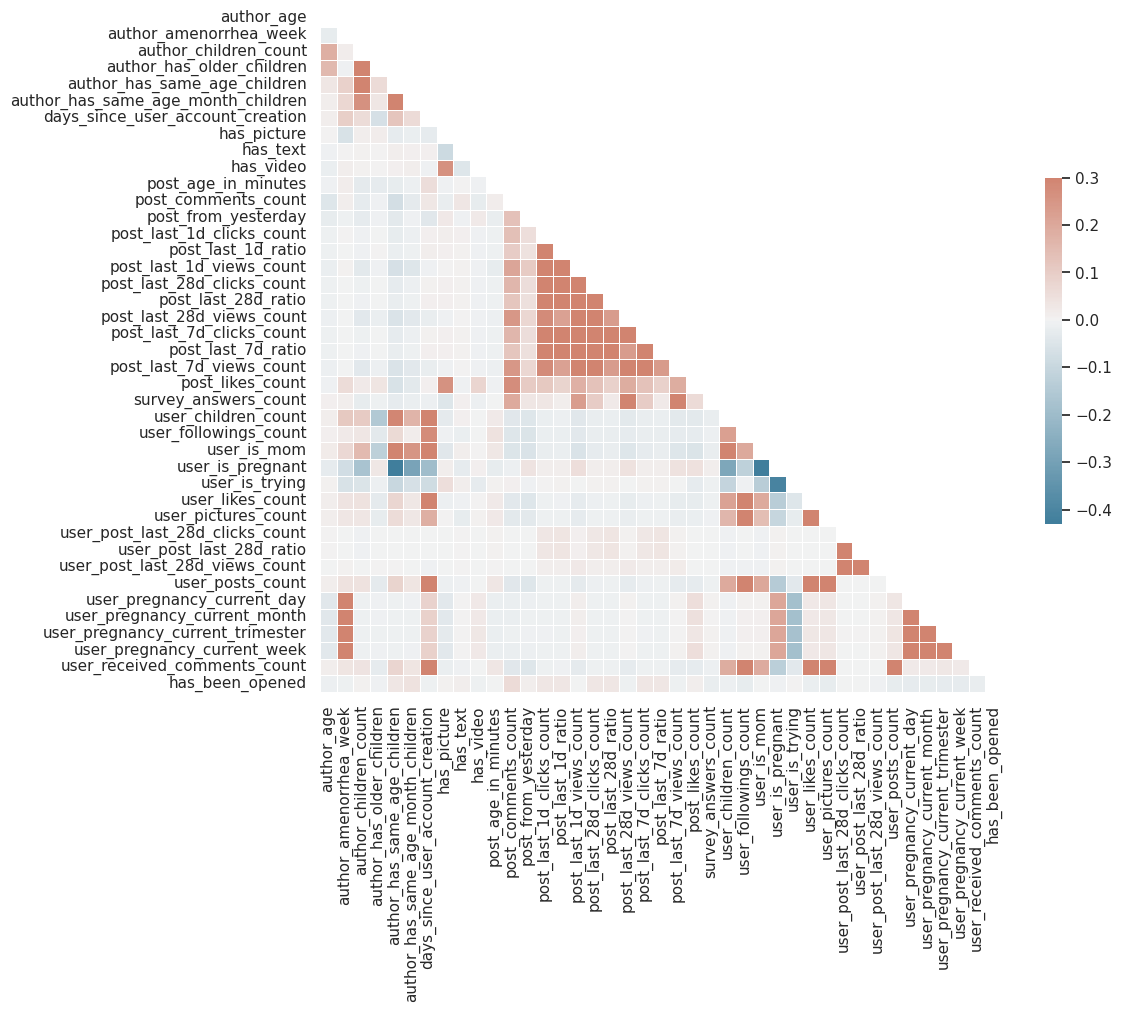

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Time exploration

<AxesSubplot: >

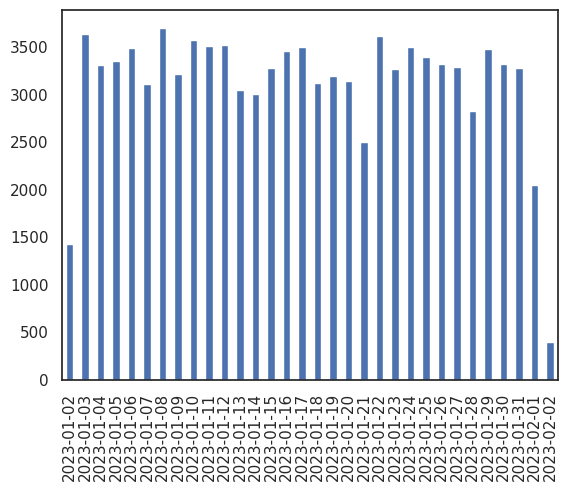

In [21]:
df.tracker_created_at.dt.date.value_counts().sort_index().plot.bar()

### Post creation dates

In [22]:
df["post_creation_date"] = (df.tracker_created_at - df.post_age_in_minutes.apply(lambda x: pd.Timedelta(minutes=x))).dt.date
df["post_creation_date_plus_one"] = df["post_creation_date"].apply(lambda x: x + pd.Timedelta(days=1))
df["post_from_yesterday"] = df.tracker_created_at.dt.date == df.post_creation_date_plus_one

<AxesSubplot: xlabel='post_creation_date'>

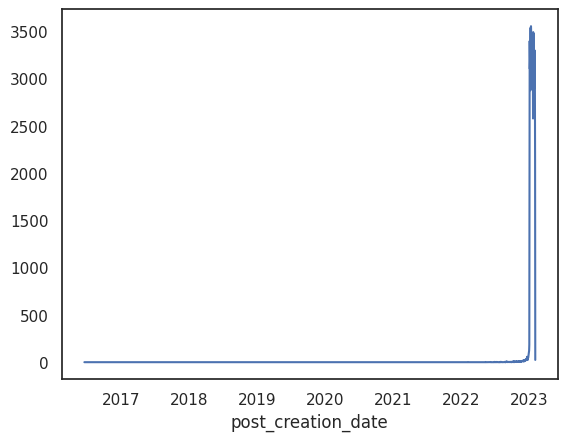

In [30]:
df.groupby("post_creation_date").post_creation_date.size().plot()

<AxesSubplot: xlabel='post_creation_date'>

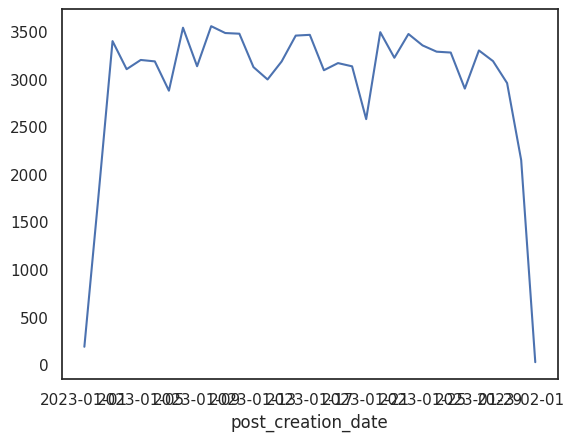

In [45]:
df[df["post_creation_date"] >= date(2023,1,1)].groupby("post_creation_date").post_creation_date.size().plot()

### Train Eval Test split

In [21]:
# We don't use the first and last days as they seem incomplete or worse, buggy
TRAIN_START_DATE = "2023-01-03"
TRAIN_END_DATE = "2023-01-27"

EVAL_START_DATE = "2023-01-28"
EVAL_END_DATE = "2023-01-30"

TEST_START_DATE = "2023-01-30"
TEST_NED_DATE = "2023-02-01"

### Label exploration

In [23]:
df["has_been_opened"].value_counts()

False    85357
True     14529
Name: has_been_opened, dtype: int64

In [24]:
# We will remove users with only one signal which is negative

In [101]:
user_vc = df.user_id.value_counts()
one_signal_users = (user_vc[user_vc <= 4]).index

pos_signal = df[df.user_id.isin(one_signal_users)]

pos_signal.loc[:, "sum_hbo"] = pos_signal.groupby("user_id").has_been_opened.transform(sum)
one_signal_users_negative = pos_signal[pos_signal["sum_hbo"] == 0].user_id

/tmp/ipykernel_381198/2936785534.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_signal.loc[:, "sum_hbo"] = pos_signal.groupby("user_id").has_been_opened.transform(sum)


In [102]:
df.shape

(99886, 54)

In [103]:
df[~df.user_id.isin(one_signal_users_negative)].shape

(51142, 54)

In [104]:
df["has_been_opened"].value_counts()

False    85357
True     14529
Name: has_been_opened, dtype: int64

In [105]:
df[~df.user_id.isin(one_signal_users_negative)]["has_been_opened"].value_counts()

False    36613
True     14529
Name: has_been_opened, dtype: int64